# Analysis: Random Forest for Profitability

Goal: Use random forest to create a model for the profitability binary-class feature.

In [1]:
import pandas as PD
import numpy as NP

import sklearn.preprocessing as PP
import imblearn.pipeline as PL
import sklearn.model_selection as MS
import imblearn.under_sampling as US
import imblearn.over_sampling as OS

import sklearn.tree as TR
import sklearn.ensemble as ES 

import sklearn.metrics as MT     # roc_auc_score, roc_curve, auc

import matplotlib.pyplot as MP
import seaborn as SB
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import plot_confusion_matrix as pcm;

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Prepare Target & Features

In [4]:
FEATURE_FILE = '../data/merge_feature.csv'
full_df = PD.read_csv(FEATURE_FILE)
full_df.head()
full_df.info()

,set_no,name,price_store,price_used,year,volume,weight,number_parts,total_parts,number_spare_parts,...,windscreens_and_fuselage_tot_prts,znap_tot_prts,category,scolor_1st,scolor_2nd,popularity,aftermarket,adj_store_price,adj_aftermarket,profitable
0,15-1,Castle Minifigures,NaN,63.0,1984,NaN,NaN,16,38,0,...,0,0,Historical,Gray,Black,NaN,NaN,NaN,NaN,NaN
1,105-1,Mail Van,NaN,102.0,1984,NaN,NaN,34,65,0,...,1,0,Modern-Town,Red,White,4.0,NaN,NaN,NaN,NaN
2,3639-1,Paddy Wagon,NaN,14.0,1984,NaN,NaN,11,12,0,...,0,0,Bigfig-Junior,Blue,Black,NaN,NaN,NaN,NaN,NaN
3,3664-1,Bertie Bulldog (Police Chief) and Constable Bu...,NaN,31.0,1984,NaN,NaN,24,63,0,...,0,0,Bigfig-Junior,Blue,Red,5.0,NaN,NaN,NaN,NaN
4,3670-1,Service Station,20.0,54.0,1984,NaN,NaN,30,54,0,...,0,0,Bigfig-Junior,Yellow,Red,NaN,34.0,49.62,4.38,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4922 entries, 0 to 4921
Columns: 134 entries, set_no to profitable
dtypes: float64(9), int64(120), object(5)
memory usage: 5.0+ MB


In [5]:
# drop volume and weight since they are sparse and colinear

full_df = full_df.drop(columns=['volume', 'weight'])

In [6]:
# drop total_parts and number_parts since they are colinear with the parts category features

full_df = full_df.drop(columns=['total_parts', 'number_parts'])

In [7]:
# filter out rows without profitable feature

full_df = full_df.loc[full_df['profitable'].isna()==False]
full_df.shape

(3832, 130)

In [8]:
# filter out rows without colors

full_df = full_df.loc[ (full_df['scolor_1st'].isna()==False) | (full_df['scolor_2nd'].isna()==False) ]
full_df.shape

(3831, 130)

In [9]:
# target series

target_sr = full_df['profitable']
target_sr.shape

(3831,)

In [10]:
# feature dataframe with one-hot encoding

columns_st = set(full_df.columns)
drop_st = set(['set_no', 'name', 'price_store', 'price_used', 'aftermarket', 'popularity', 
               'adj_store_price', 'adj_aftermarket', 'profitable'])
feature_st = columns_st.difference(drop_st)

feature_cat_df = full_df[list(feature_st)]

feature_df = PD.get_dummies(feature_cat_df, drop_first= True, 
               columns=['category', 'scolor_1st', 'scolor_2nd'])
feature_df.shape
feature_df.columns

(3831, 149)

Index(['string_bands_and_reels_tot_prts', 'technic_beams_special_cnt_prts',
       'transportation_-_sea_and_air_tot_prts',
       'string_bands_and_reels_cnt_prts', 'bricks_special_cnt_prts',
       'tools_tot_prts', 'transportation_-_sea_and_air_cnt_prts',
       'mechanical_cnt_prts', 'bars_ladders_and_fences_tot_prts',
       'technic_beams_special_tot_prts',
       ...
       'scolor_1st_Yellow', 'scolor_2nd_Blue', 'scolor_2nd_Brown',
       'scolor_2nd_Gray', 'scolor_2nd_Green', 'scolor_2nd_Red',
       'scolor_2nd_Tan', 'scolor_2nd_Transparent', 'scolor_2nd_White',
       'scolor_2nd_Yellow'],
      dtype='object', length=149)

## Split Test & Standardize

In [11]:
TEST_SPLIT = 0.2
SEED = 1

In [12]:
y_train, y_test, X_train, X_test = MS.train_test_split(target_sr, feature_df, 
                                                       stratify=feature_df['year'], 
                                                       test_size=TEST_SPLIT, random_state=SEED)

y_train.shape
y_test.shape 
X_train.shape
X_test.shape

(3064,)

(767,)

(3064, 149)

(767, 149)

In [13]:
# fit the scalers based on the training set
# must include all features, including one-hot encoded ones
# target variable does not need to be transformed

scaler = PP.StandardScaler()
scaler.fit(X_train)
scaler.mean_.shape

StandardScaler(copy=True, with_mean=True, with_std=True)

(149,)

In [14]:
# create standardized feature sets

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std.shape

(3064, 149)

## Decision Tree Classifier

In [15]:
# setup for several algorithms

ESTIMATORS = 1000
algorithm_ls = []
alpha_ls = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

In [16]:
# standalone 

dtc = TR.DecisionTreeClassifier()
dtc.fit(X_train_std, y_train)
dtc.score(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

0.9983681462140992

In [17]:
# use cross validation to evaluate algorithm

scaler = PP.StandardScaler()
decisiontree = TR.DecisionTreeClassifier()
pipeline = PL.Pipeline([('transformer', scaler), ('estimator', decisiontree)])

cv_results = MS.cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True)
cv_results

{'fit_time': array([0.11884308, 0.09753108, 0.111552  , 0.09439278, 0.08938599]),
 'score_time': array([0.00369096, 0.002877  , 0.00271082, 0.00280905, 0.00307894]),
 'test_score': array([0.74918567, 0.69331158, 0.71615008, 0.71568627, 0.68464052]),
 'train_score': array([0.99877551, 0.99836801, 0.99836801, 0.99877651, 0.99796085])}

In [18]:
new_dx = {
    'type': 'decision-tree',
    #'lambda': NP.min(alpha_ls) - 0.5 *NP.min(alpha_ls), 
    'cvtrain_score': cv_results['train_score'].mean(),
    'cvtrain_error': cv_results['train_score'].std(),
    'cvtest_score': cv_results['test_score'].mean(),
    'cvtest_error': cv_results['test_score'].std(),
}
algorithm_ls.append(new_dx)
new_dx

{'type': 'decision-tree',
 'cvtrain_score': 0.9984497787150506,
 'cvtrain_error': 0.0003050501182839549,
 'cvtest_score': 0.7117948258171725,
 'cvtest_error': 0.02241059188115666}

## Random Forest with Imbalance

In [19]:
# standalone 

randforest = ES.RandomForestClassifier(n_estimators=ESTIMATORS)
randforest.fit(X_train_std, y_train)
randforest.score(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.9983681462140992

In [20]:
# use cross validation to evaluate algorithm

scaler = PP.StandardScaler()
randforest = ES.RandomForestClassifier(n_estimators=ESTIMATORS)
pipeline = PL.Pipeline([('transformer', scaler), ('estimator', randforest)])

cv_results = MS.cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True)
cv_results

{'fit_time': array([6.3686738 , 6.17231798, 6.85524106, 6.26266193, 6.56034517]),
 'score_time': array([0.19331813, 0.22453117, 0.22831511, 0.22426105, 0.27013803]),
 'test_score': array([0.82247557, 0.80261011, 0.7862969 , 0.79084967, 0.76633987]),
 'train_score': array([0.99877551, 0.99836801, 0.99836801, 0.99877651, 0.99796085])}

In [21]:
new_dx = {
    'type': 'random-f',
    #'lambda': NP.min(alpha_ls) - 0.5 *NP.min(alpha_ls), 
    'cvtrain_score': cv_results['train_score'].mean(),
    'cvtrain_error': cv_results['train_score'].std(),
    'cvtest_score': cv_results['test_score'].mean(),
    'cvtest_error': cv_results['test_score'].std(),
}
new_dx

{'type': 'random-f',
 'cvtrain_score': 0.9984497787150506,
 'cvtrain_error': 0.0003050501182839549,
 'cvtest_score': 0.7937144254396251,
 'cvtest_error': 0.018541464469293483}

In [22]:
# use cross validation to get test results for ROC curve

scaler = PP.StandardScaler()
randforest = ES.RandomForestClassifier(n_estimators=ESTIMATORS)
pipeline = PL.Pipeline([('transformer', scaler), ('estimator', randforest)])

predict_imbal = MS.cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict_proba')
predict_imbal

array([[0.969 , 0.031 ],
       [0.7975, 0.2025],
       [0.6   , 0.4   ],
       ...,
       [0.806 , 0.194 ],
       [0.691 , 0.309 ],
       [0.545 , 0.455 ]])

In [23]:
# get the TP, FP, and thresholds rates for ROC 

fpr_imbal, tpr_imbal, thresh_imbal = MT.roc_curve(y_train, predict_imbal[:,1])
tpr_imbal.shape
fpr_imbal.shape
type(thresh_imbal)

(874,)

(874,)

numpy.ndarray

In [24]:
# get the Roc values for some benchmark thresholds
# use >= to threshold because actual thrshold value may not exist

thresh25_idx = NP.where(thresh_imbal >= 0.25)
thresh50_idx = NP.where(thresh_imbal >= 0.50)
thresh75_idx = NP.where(thresh_imbal >= 0.75)

thresh_tpr_imbal = [ tpr_imbal[thresh25_idx][-1], tpr_imbal[thresh50_idx][-1], tpr_imbal[thresh75_idx][-1] ]
thresh_fpr_imbal = [ fpr_imbal[thresh25_idx][-1], fpr_imbal[thresh50_idx][-1], fpr_imbal[thresh75_idx][-1] ]

thresh_tpr_imbal 
thresh_fpr_imbal

[0.804374240583232, 0.3839611178614824, 0.06804374240583232]

[0.32663989290495316, 0.05310129406514949, 0.005800981704596163]

## Random Forest with Undersampling

In [25]:
# after splitting, balance the dataset

undersampler = US.RandomUnderSampler()
X_under, y_under = undersampler.fit_resample(X_train, y_train)
X_under.shape
y_under.shape

(1646, 149)

(1646,)

In [26]:
# use cross validation to get test results for ROC curve

sampler = US.RandomUnderSampler()
scaler = PP.StandardScaler()
randforest = ES.RandomForestClassifier(n_estimators=ESTIMATORS)
pipeline = PL.Pipeline([('sampler', sampler), ('transformer', scaler), ('estimator', randforest)])

predict_under = MS.cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict_proba')
predict_under

array([[0.893     , 0.107     ],
       [0.63956667, 0.36043333],
       [0.311     , 0.689     ],
       ...,
       [0.534     , 0.466     ],
       [0.527     , 0.473     ],
       [0.39      , 0.61      ]])

In [27]:
# get the TP, FP, and thresholds rates for ROC 

fpr_under, tpr_under, thresh_under = MT.roc_curve(y_train, predict_under[:,1])
tpr_under.shape
fpr_under.shape

(911,)

(911,)

In [28]:
# get the Roc values for some benchmark thresholds
# use >= to threshold because actual thrshold value may not exist

thresh25_idx = NP.where(thresh_under >= 0.25)
thresh50_idx = NP.where(thresh_under >= 0.50)
thresh75_idx = NP.where(thresh_under >= 0.75)

thresh_tpr_under = [ tpr_under[thresh25_idx][-1], tpr_under[thresh50_idx][-1], tpr_under[thresh75_idx][-1] ]
thresh_fpr_under = [ fpr_under[thresh25_idx][-1], fpr_under[thresh50_idx][-1], fpr_under[thresh75_idx][-1] ]

thresh_tpr_under 
thresh_fpr_under

[0.9708383961117861, 0.7083839611178615, 0.26123936816524906]

[0.7929495760821063, 0.25301204819277107, 0.04060687193217314]

## Random Forest with SMOTE

In [29]:
# use cross validation to get test results for ROC curve

sampler = OS.SMOTE()
scaler = PP.StandardScaler()
randforest = ES.RandomForestClassifier(n_estimators=ESTIMATORS)
pipeline = PL.Pipeline([('sampler', sampler), ('transformer', scaler), ('estimator', randforest)])

predict_over = MS.cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict_proba')
predict_over

array([[0.929, 0.071],
       [0.747, 0.253],
       [0.45 , 0.55 ],
       ...,
       [0.629, 0.371],
       [0.657, 0.343],
       [0.471, 0.529]])

In [30]:
# get the TP, FP, and thresholds rates for ROC 

fpr_over, tpr_over, thresh_over = MT.roc_curve(y_train, predict_over[:,1])
tpr_over.shape
fpr_over.shape

(920,)

(920,)

In [31]:
# get the Roc values for some benchmark thresholds
# use >= to threshold because actual thrshold value may not exist

thresh25_idx = NP.where(thresh_over >= 0.25)
thresh50_idx = NP.where(thresh_over >= 0.50)
thresh75_idx = NP.where(thresh_over >= 0.75)

thresh_tpr_over = [ tpr_over[thresh25_idx][-1], tpr_over[thresh50_idx][-1], tpr_over[thresh75_idx][-1] ]
thresh_fpr_over = [ fpr_over[thresh25_idx][-1], fpr_over[thresh50_idx][-1], fpr_over[thresh75_idx][-1] ]

thresh_tpr_over 
thresh_fpr_over

[0.9076549210206561, 0.5236938031591738, 0.14702308626974483]

[0.5323516287371709, 0.11289602855867917, 0.0178491744756805]

## Compare Balances

In [32]:
IMBAL_COLOR = 'green'
UNDER_COLOR = 'orange'
OVER_COLOR = 'red'
SMOTE_COLOR = 'blue'
thresh_ls = ['0.25', '0.50', '0.75']

def label_point(x, y, labels, ax, color):
    x_sr = PD.Series(x)
    y_sr = PD.Series(y)
    label_sr = PD.Series(labels)
    a = PD.concat({'x': x_sr, 'y': y_sr, 'labels': label_sr}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['labels']), color=color)

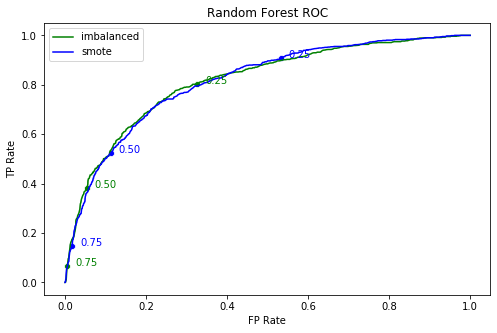

In [33]:
fig, axs = MP.subplots(1, 1, figsize=(8, 5), facecolor='white')

SB.lineplot(y=tpr_imbal, x=fpr_imbal, ax=axs, label='imbalanced', color=IMBAL_COLOR)
SB.scatterplot(y=thresh_tpr_imbal, x=thresh_fpr_imbal, ax=axs, color=IMBAL_COLOR)
label_point(thresh_fpr_imbal, thresh_tpr_imbal, thresh_ls, axs, IMBAL_COLOR)

# SB.lineplot(y=tpr_under, x=fpr_under, ax=axs, label='undersampled', color=UNDER_COLOR)
# SB.scatterplot(y=thresh_tpr_under, x=thresh_fpr_under, ax=axs, color=UNDER_COLOR)
# label_point(thresh_fpr_under, thresh_tpr_under, thresh_ls, axs, UNDER_COLOR)

SB.lineplot(y=tpr_over, x=fpr_over, ax=axs, label='smote', color=SMOTE_COLOR)
SB.scatterplot(y=thresh_tpr_over, x=thresh_fpr_over, ax=axs, color=SMOTE_COLOR)
label_point(thresh_fpr_over, thresh_tpr_over, thresh_ls, axs, SMOTE_COLOR)

axs.set(title='Random Forest ROC', xlabel='FP Rate', ylabel='TP Rate')

MP.show();

In [34]:
# AUC for all balance-types

MT.roc_auc_score(y_train, predict_imbal[:, 1])
MT.roc_auc_score(y_train, predict_under[:, 1])
MT.roc_auc_score(y_train, predict_over[:, 1])

0.8152033000369238

0.805005359632129

0.8143813271175698

## Fine-Tune the Chosen Balance

In [35]:
# setup the grid-search
# not sure for process on grid-search, the best parameters keep changing, as if the default are best

SEED = 666
sampler = OS.SMOTE(random_state=SEED)
scaler = PP.StandardScaler()
randforest = ES.RandomForestClassifier(random_state=SEED)
pipeline = PL.Pipeline([('sampler', sampler), ('transformer', scaler), ('estimator', randforest)])

param_dx = {
    'estimator__n_estimators': [120, 140, 160],
    'estimator__max_depth': [10, 20, 30],
    'estimator__min_impurity_decrease': [0.000001, 0.00001, 0.0001],
    }

searcher = MS.GridSearchCV(pipeline, param_dx, scoring='accuracy', cv=5)

In [36]:
# run the grid search

%timeit
searcher.fit(X_train, y_train);

In [37]:
# check the best parameters fund by grid search

best_parameters = searcher.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

train_pred = searcher.predict(X_train)
train_accuracy = MT.accuracy_score(y_train, train_pred)
test_pred = searcher.predict(X_test)
test_accuracy = MT.accuracy_score(y_test, test_pred)

print("")
print("Training Accuracy: {:.4}%".format(train_accuracy * 100))
print("")
print("Validation Accuracy: {:.4}%".format(test_accuracy * 100))

guess_TP = 0
guess_TN = len(y_test[y_test==0])
guess_FP = 0
guess_FN = len(y_test[y_test==1])

print("")
print("Random Guess Accuracy: {:.4}%".format( 
    (guess_TP + guess_TN) / (guess_TP + guess_TN + guess_FP + guess_FN) * 100))

Grid Search found the following optimal parameters: 
estimator__max_depth: 30
estimator__min_impurity_decrease: 1e-05
estimator__n_estimators: 160

Training Accuracy: 99.8%

Validation Accuracy: 80.44%

Random Guess Accuracy: 74.84%


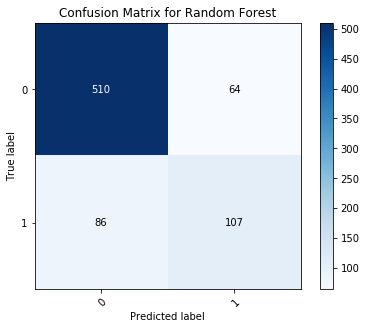

In [38]:
# confusion matrix

pcm.plot_confusion_matrix(y_test.astype('int64'),
                          test_pred.astype('int64'),
                          title="Confusion Matrix for Random Forest",
                          classes=NP.array([0,1]))

# a bug in the current version of matplotlib shifts the default ylim, and the code below corrects it
MP.gca().set_ylim(1.5, -0.5);

In [39]:
# balance the test set for investigation

undersampler = US.RandomUnderSampler()
X_test_under, y_test_under = undersampler.fit_resample(X_test, y_test)
X_test_under.shape
y_test_under.shape

(386, 149)

(386,)

In [40]:
train_pred = searcher.predict(X_train)
train_accuracy = MT.accuracy_score(y_train, train_pred)
test_pred = searcher.predict(X_test_under)
test_accuracy = MT.accuracy_score(y_test_under, test_pred)

print("")
print("Training Accuracy: {:.4}%".format(train_accuracy * 100))
print("")
print("Validation Accuracy: {:.4}%".format(test_accuracy * 100))

guess_TP = 0
guess_TN = len(y_test_under[y_test_under==0])
guess_FP = 0
guess_FN = len(y_test_under[y_test_under==1])

print("")
print("Random Guess Accuracy: {:.4}%".format( 
    (guess_TP + guess_TN) / (guess_TP + guess_TN + guess_FP + guess_FN) * 100))


Training Accuracy: 99.8%

Validation Accuracy: 71.5%

Random Guess Accuracy: 50.0%


## Feature Importance

In [41]:
importance_ls = list(searcher.best_estimator_.named_steps['estimator'].feature_importances_)
columns_ls = X_train.columns
feature_ls = []

for idx, ftr in enumerate(columns_ls):
    new_dx = {
        'feature': ftr,
        'importance': importance_ls[idx],
    }
    feature_ls.append(new_dx)
    
importance_df = PD.DataFrame(feature_ls)
importance_df.head()
importance_df.info()

,feature,importance
0,string_bands_and_reels_tot_prts,0.004606
1,technic_beams_special_cnt_prts,0.002125
2,transportation_-_sea_and_air_tot_prts,0.006547
3,string_bands_and_reels_cnt_prts,0.004274
4,bricks_special_cnt_prts,0.007933


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 2 columns):
feature       149 non-null object
importance    149 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [42]:
importance_df.sort_values('importance', ascending=False).head(10)

,feature,importance
41,year,0.048906
109,wheels_and_tyres_cnt_prts,0.023451
53,plates_tot_prts,0.019216
94,wheels_and_tyres_tot_prts,0.018906
33,bionicle_hero_factory_and_constraction_tot_prts,0.017332
38,number_colors,0.017083
87,bricks_tot_prts,0.017047
73,minifigs_tot_prts,0.016355
122,category_Lego-Brand,0.016141
66,minifig_accessories_tot_prts,0.015505
